# Task

Implement a model using machine learning classifiers, which will determine whether the transaction is fraudulent or not.

Requirements: 
* Fraud precision > 90%
* Maximum Fraud recall

# Data loading and invistigation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from pandas.tools.plotting import parallel_coordinates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix
from sklearn.metrics import f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
# Load all data to dataframe
frame = pd.read_excel('DatasetTask2SolidDataAnalyst.xlsx', sheet_name='Sheet1')

In [3]:
# Get dataframe shape
frame.shape

(94579, 194)

Check the balance of data for both classes.

In [4]:
occ = frame['fraud'].value_counts()
occ/len(frame.index)

0    0.957263
1    0.042737
Name: fraud, dtype: float64

Split data to features and labels.

In [5]:
y = frame['fraud']
X = frame.loc[:, frame.columns != 'fraud']

Split data to train and test Sets.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Data resampling

Fraud cases are in minority. To manage class imbalance I will use SMOTE.
Synthetic Minority Oversampling Technique uses charecteristics of nearest neighbours of fraud cases to create new synthetic fraud cases, and therby avoids diplications observations.
Works good only if fraud cases are quite similar to each other.

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
method = SMOTE(kind='regular')
X_train, y_train = method.fit_sample(X_train, y_train)

Create function to visualize data.

In [9]:
def visualize_data(X, y):
    pca = sklearnPCA(n_components=2) #2-dimensional PCA
    transformed = pd.DataFrame(pca.fit_transform(X))
    plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Normal', c='red')
    plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Fraud', c='blue')

    plt.legend()
    plt.show()

Show data before resampling.

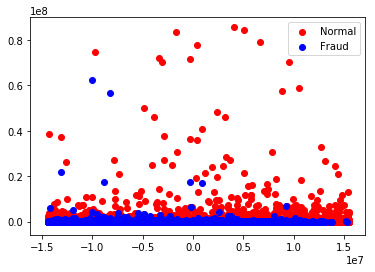

In [10]:
visualize_data(X, y)

Show data after resampling.

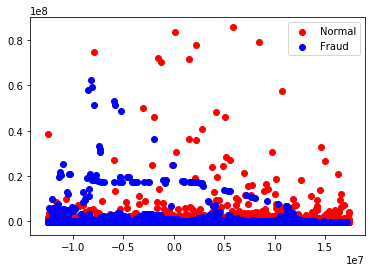

In [11]:
visualize_data(X_train, y_train)

# Predict Fraud

Create function that will run model and return results.

In [12]:
def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    report = classification_report(y_test, pred)
    return matrix, report, pred

Create function that will Print Stats for model.

In [13]:
def print_stats(cmat, report, y_test, pred):
   # separate out the confusion matrix components
    tpos = cmat[0][0]
    fneg = cmat[0][1]
    fpos = cmat[1][0]
    tneg = cmat[1][1]
    # calculate F!, Recall scores
    f1Score = round(f1_score(y_test, pred), 2)
    recallScore = round(recall_score(y_test, pred), 2)
    # calculate and display metrics
    print(cmat)
    print(report)
    # calculate accuracy for fraud data
    print('Fraud precision:' + str(np.round(100*float(tneg)/float(tneg+fneg), 2))+'%')
    print('Fraud recall:'+str(np.round(100*float(tneg)/float(tneg+fpos), 2))+'%')
    print( 'Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
    print( 'Cohen Kappa: '+ str(np.round(cohen_kappa_score(y_test, pred),3)))
    print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
    print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))

Use simple logistic regression to predict fraud.

In [14]:
# Fit a logistic regression model to the data
model = LogisticRegression(solver='lbfgs')
conf_matr, report, predicted = run_model(model, X_train, y_train, X_test, y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

[[27092    43]
 [ 1236     3]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27135
           1       0.07      0.00      0.00      1239

   micro avg       0.95      0.95      0.95     28374
   macro avg       0.51      0.50      0.49     28374
weighted avg       0.92      0.95      0.93     28374

Fraud precision:6.52%
Fraud recall:0.24%
Accuracy: 95.63%
Cohen Kappa: 0.002
Sensitivity/Recall for Model : 0.0
F1 Score for Model : 0.0


Logistic regression model has very low precision and recall. 
Logistic regression assumes that there is one smooth linear decision boundary.
Let's try Random Forest Classifier now.

In [15]:
model = RandomForestClassifier(random_state=6, class_weight='balanced', n_estimators=100)
conf_matr, report, predicted = run_model(model, X_train, y_train, X_test, y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

[[27075    60]
 [  831   408]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27135
           1       0.87      0.33      0.48      1239

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.92      0.66      0.73     28374
weighted avg       0.97      0.97      0.96     28374

Fraud precision:87.18%
Fraud recall:32.93%
Accuracy: 95.63%
Cohen Kappa: 0.465
Sensitivity/Recall for Model : 0.33
F1 Score for Model : 0.48


Random Forest Classifier performs much better. Precision is close to requirements.

Let's try XGBCLassifier with different parameters to predict labels.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model1 = XGBClassifier(max_depth = 10, n_jobs = 4, subsample=0.7 )
# Get the results 
conf_matr, report, predicted = run_model(model1, X_train.as_matrix(), y_train, X_test.as_matrix(), y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

C:\Users\dalap\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


[[27058    77]
 [  654   585]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     27135
           1       0.88      0.47      0.62      1239

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.93      0.73      0.80     28374
weighted avg       0.97      0.97      0.97     28374

Fraud precision:88.37%
Fraud recall:47.22%
Accuracy: 95.63%
Cohen Kappa: 0.603
Sensitivity/Recall for Model : 0.47
F1 Score for Model : 0.62


In [23]:
model2 = XGBClassifier(max_depth=8, eta=10**-1, silent=1, min_child_weight=3, subsample= 0.7 ,early_stopping_rounds=10, objective="count:poisson",colsample_bytree=0.65)

conf_matr, report, predicted = run_model(model2, X_train.as_matrix(), y_train, X_test.as_matrix(), y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

C:\Users\dalap\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


[[27078    57]
 [  795   444]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27135
           1       0.89      0.36      0.51      1239

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.93      0.68      0.75     28374
weighted avg       0.97      0.97      0.96     28374

Fraud precision:88.62%
Fraud recall:35.84%
Accuracy: 95.63%
Cohen Kappa: 0.498
Sensitivity/Recall for Model : 0.36
F1 Score for Model : 0.51


First model showed better result. XGBoost gives precision close to requirement (89%) and high recall(47%).

Let's get importance parameters from this model for top 30 features.

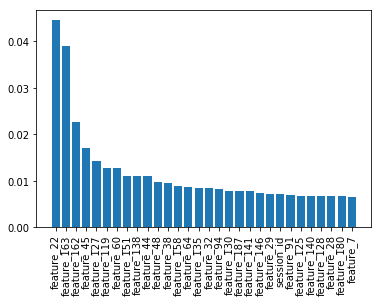

In [24]:
from matplotlib import pyplot

features = X.columns.to_frame().reset_index(drop=True)
features['importance'] = model1.feature_importances_
features.columns = ['name', 'importance']
main_features = features.sort_values(by=['importance'], ascending=False).head(30)
pyplot.bar(range(len(main_features)), main_features.importance)
x_pos = np.arange(len(main_features))
pyplot.xticks(x_pos, main_features.name, rotation='vertical')
pyplot.show()

As we see XBGClassifier and Random Forest Classifier give the best result. Let's use ensemle of multiple methods to improve predictive model.

My empirical tests have shown that the best results are obtained by combining three machine learning methods - XGBClassifier, RandomForestClassifier and DecisionTreeClassifier.

In [26]:

# Define the three classifiers to use in the ensemble
clf1 = XGBClassifier(max_depth = 9, n_jobs = 4)
clf2 = RandomForestClassifier(random_state=6, criterion='gini', max_depth=4, max_features='auto', n_estimators=30)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('xgb', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard', weights=[4, 4, 2], flatten_transform=True)
conf_matr, report, predicted = run_model(ensemble_model, X_train.as_matrix(), y_train, X_test.as_matrix(), y_test)
# Print the classifcation report and confusion matrix
print_stats(conf_matr, report, y_test, predicted)

C:\Users\dalap\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


[[27095    40]
 [  823   416]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     27135
           1       0.91      0.34      0.49      1239

   micro avg       0.97      0.97      0.97     28374
   macro avg       0.94      0.67      0.74     28374
weighted avg       0.97      0.97      0.96     28374

Fraud precision:91.23%
Fraud recall:33.58%
Accuracy: 95.63%
Cohen Kappa: 0.479
Sensitivity/Recall for Model : 0.34
F1 Score for Model : 0.49


Precision (91%) meets the desired level.

Method predict_proba() will give the likelihood of fraud for scoring cards.